# Sorting out images from Food101 dataset

Notebook to sort out the images in the Food101 dataset into common computer vision data layout, for example:

```
# Example of file structure
pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

To replicate this notebook you'll need the data downloaded from either of the following:
1. https://www.kaggle.com/kmader/food41 
2. https://www.kaggle.com/dansbecker/food-101 (this also works)

However, the code below works on the first link's file structure.

Once you've got the raw zip file, unzip it and put in the current working directory.

The following code should run to create the following data splits (based on what you downloaded from above):

* Binary dataset (split steak/pizza into train & test folders)
* Binary dataset of 10% of data (split steak/pizza into & test folders) 
* 10 class dataset (split 10 classes into train & test folders)
* 10 class dataset of 10% of data (select random 10% of training data, keep test data the same)
* Create all class dataset (split all classes into train & test folders)
* Create all class dataset with 10% of data (select random 10% of training data, keep test data the same)

In [46]:
!dir data\food_101_all_data\images

 Volume in drive D is New Volume
 Volume Serial Number is D6C8-3FC2

 Directory of D:\personal\tensorflow-handson\03_computer_vision_with_tensorflow\data\food_101_all_data\images

11/24/2024  09:30 AM    <DIR>          .
11/24/2024  09:30 AM    <DIR>          ..
11/24/2024  09:29 AM    <DIR>          apple_pie
11/24/2024  09:29 AM    <DIR>          baby_back_ribs
11/24/2024  09:29 AM    <DIR>          baklava
11/24/2024  09:29 AM    <DIR>          beef_carpaccio
11/24/2024  09:29 AM    <DIR>          beef_tartare
11/24/2024  09:29 AM    <DIR>          beet_salad
11/24/2024  09:29 AM    <DIR>          beignets
11/24/2024  09:29 AM    <DIR>          bibimbap
11/24/2024  09:29 AM    <DIR>          bread_pudding
11/24/2024  09:29 AM    <DIR>          breakfast_burrito
11/24/2024  09:29 AM    <DIR>          bruschetta
11/24/2024  09:29 AM    <DIR>          caesar_salad
11/24/2024  09:29 AM    <DIR>          cannoli
11/24/2024  09:29 AM    <DIR>          caprese_salad
11/24/2024  09:29 AM   

In [24]:
import json
from tqdm.notebook import tqdm

In [25]:
# Get labels
def get_labels(label_path):
    """
    Accepts a label path (in the form of a JSON) and returns the file
    as a Python object.
    """
    with open(label_path) as f:
        return json.load(f)

train_labels = get_labels("data/food_101_all_data/meta/meta/train.json")
test_labels = get_labels("data/food_101_all_data/meta/meta/test.json")

In [29]:
print(len(train_labels['churros']))
print(len(test_labels['churros']))

750
250


## Create target class folders and move images there

In [30]:
import shutil
import os

def copy_images(parent_folder, new_subset, dataset, target_labels):
    """
    Copies `labels[target_labels]` images from `parent_folder` to
    `new_subset` (named after `dataset`) folder.
    
    E.g. move steak images to data/steak_subset/train/ & 
    data/steak_subset/test/
    
    Parameters
    --------
    parent_folder (str) - original folder path with all data
    new_subset (str) - name of parent folder to copy to
    dataset (str) - which dataset? (train or test)
    labels (list) - list of training or test labels
    target_labels (list) - list of target labels to copy e.g. ["steak", "pizza"]
    """
    # Get the appropriate labels
    print(f"\nUsing {dataset} labels...")
    labels = get_labels("data/food_101_all_data/meta/meta/" + dataset + ".json")
    
    # Loop through target labels
    for i in target_labels:
        # Make target directory
        os.makedirs(parent_folder + "/" + new_subset + "/" + dataset + "/" + i, 
                    exist_ok=True)
        
        # Go through labels and get appropriate classes
        images_moved = [] # Keep track of images moved
        for j in labels[i]:
            # Create original image path and new path
            og_path = parent_folder + "/food_101_all_data/images/" + j + ".jpg"
            new_path = parent_folder + "/" + new_subset + "/" + dataset + "/" + j + ".jpg"
            
            # Copy images from old path to new path
            shutil.copy2(og_path, new_path)
            images_moved.append(new_path)
        print(f"Copied {len(images_moved)} images from {dataset} dataset {i} class...")

## Create function to get random sample of images

Hmmm... this could probably be put into the `copy_images()` function. As in, only get a certain percent of images when looping through.

E.g. "only copy every X (1/10) images..."

In [50]:
import os
import shutil
from tqdm import tqdm
import random  # Import the random module

def get_percent_images(target_dir, new_dir, sample_amount=0.1, random_state=42):
    """
    Get sample_amount percentage of random images from target_dir and copy them to new_dir.
    
    Preserves subdirectory file names.
    
    E.g. target_dir=pizza_steak/train/steak/all_files 
                -> new_dir_name/train/steak/X_percent_of_all_files
                
    Parameters
    --------
    target_dir (str) - file path of directory you want to extract images from
    new_dir (str) - new directory path you want to copy original images to
    sample_amount (float), default 0.1 - percentage of images to copy (e.g. 0.1 = 10%)
    random_state (int), default 42 - random seed value 
    """
    # Set random seed for reproducibility
    random.seed(random_state)
    
    # Get a list of dictionaries of image files in target_dir
    # e.g. [{"class_name":["2348348.jpg", "2829119.jpg"]}]
    images = [{dir_name: os.listdir(target_dir + dir_name)} for dir_name in os.listdir(target_dir)]

    for i in images:
        for k, v in i.items():
            # How many images to sample?
            sample_number = round(int(len(v)*sample_amount))
            print(f"There are {len(v)} total images in '{target_dir+k}' so we're going to copy {sample_number} to the new directory.")
            print(f"Getting {sample_number} random images for {k}...")
            random_images = random.sample(v, sample_number)

            # Make new dir for each key
            new_target_dir = new_dir + k
            print(f"Making dir: {new_target_dir}")
            os.makedirs(new_target_dir, exist_ok=True)

            # Keep track of images moved
            images_moved = []

            # Create file paths for original images and new file target
            print(f"Copying images from: {target_dir}\n\t\t to: {new_target_dir}/\n")
            for file_name in tqdm(random_images):
                og_path = target_dir + k + "/" + file_name
                new_path = new_target_dir + "/" + file_name

                # Copy images from OG path to new path
                shutil.copy2(og_path, new_path)
                images_moved.append(new_path)

            # Make sure number of images moved is correct
            assert len(os.listdir(new_target_dir)) == sample_number
            assert len(images_moved) == sample_number

## Make binary data (pizza and steak)

Two classes: steak and pizza.

In [32]:
parent_folder = "data"
target_labels = ["steak", "pizza"]
new_subset = "pizza_steak"
datasets = ["train", "test"]

# Copy training/test images
for i in datasets:
    copy_images(parent_folder=parent_folder,
                new_subset=new_subset,
                dataset=i,
                #labels=labels,
                target_labels=target_labels)


Using train labels...
Copied 750 images from train dataset steak class...
Copied 750 images from train dataset pizza class...

Using test labels...
Copied 250 images from test dataset steak class...
Copied 250 images from test dataset pizza class...


In [33]:
# Should be 750 for training set and 250 for test set
print("Number of images in training set:", len(os.listdir("data/pizza_steak/train/steak")))
print("Number of images in test set:", len(os.listdir("data/pizza_steak/test/steak")))

Number of images in training set: 750
Number of images in test set: 250


In [34]:
# Make sure there are no overlaps in the training and test sets
# Get two sets of filenames from train/test and make sure the output equals 0
train_files = set(os.listdir("data/pizza_steak/train/steak"))
test_files = set(os.listdir("data/pizza_steak/test/steak"))

# There should be no intersection of file names in training/test set
assert len(train_files.intersection(test_files)) == 0

## Make 10% binary class dataset

Use this as an example of how a network from scratch (trained on full binary class dataset) and then using transfer learning on the 10% of data and seeing how it performs.

In [45]:
# Need 10% of train data
!dir Data\pizza_steak

 Volume in drive D is New Volume
 Volume Serial Number is D6C8-3FC2

 Directory of D:\personal\tensorflow-handson\03_computer_vision_with_tensorflow\Data\pizza_steak

11/24/2024  12:11 PM    <DIR>          .
11/24/2024  12:11 PM    <DIR>          ..
11/24/2024  12:11 PM    <DIR>          test
11/24/2024  12:11 PM    <DIR>          train
               0 File(s)              0 bytes
               4 Dir(s)  53,075,091,456 bytes free


In [51]:

# Make 10% sample binary class dataset (of training data only)
get_percent_images(target_dir="data/pizza_steak/train/",
                   new_dir="data/pizza_steak_10_percent/train/",
                   sample_amount=0.1, # 10%
                   random_state=42)

There are 750 total images in 'data/pizza_steak/train/pizza' so we're going to copy 75 to the new directory.
Getting 75 random images for pizza...
Making dir: data/pizza_steak_10_percent/train/pizza
Copying images from: data/pizza_steak/train/
		 to: data/pizza_steak_10_percent/train/pizza/





  0%|                                                                                                                                                                                      | 0/75 [00:00<?, ?it/s]

 12%|████████████████████▉                                                                                                                                                         | 9/75 [00:00<00:00, 86.10it/s]

 24%|█████████████████████████████████████████▌                                                                                                                                   | 18/75 [00:00<00:00, 64.49it/s]

 33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 25/75 [00:00<00:00, 55.39it/s]

 41%|███████████████████████████████████████████████████████████████████████▌                                                                         

There are 750 total images in 'data/pizza_steak/train/steak' so we're going to copy 75 to the new directory.
Getting 75 random images for steak...
Making dir: data/pizza_steak_10_percent/train/steak
Copying images from: data/pizza_steak/train/
		 to: data/pizza_steak_10_percent/train/steak/





  0%|                                                                                                                                                                                      | 0/75 [00:00<?, ?it/s]

  8%|█████████████▉                                                                                                                                                                | 6/75 [00:00<00:01, 55.45it/s]

 16%|███████████████████████████▋                                                                                                                                                 | 12/75 [00:00<00:01, 51.64it/s]

 24%|█████████████████████████████████████████▌                                                                                                                                   | 18/75 [00:00<00:01, 49.93it/s]

 32%|███████████████████████████████████████████████████████▎                                                                                         

In [52]:
# Make 1% sample binary class dataset
get_percent_images(target_dir="data/pizza_steak/train/",
                   new_dir="data/pizza_steak_1_percent/train/",
                   sample_amount=0.01, # 1%
                   random_state=42)

There are 750 total images in 'data/pizza_steak/train/pizza' so we're going to copy 7 to the new directory.
Getting 7 random images for pizza...
Making dir: data/pizza_steak_1_percent/train/pizza
Copying images from: data/pizza_steak/train/
		 to: data/pizza_steak_1_percent/train/pizza/





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 860.87it/s]


There are 750 total images in 'data/pizza_steak/train/steak' so we're going to copy 7 to the new directory.
Getting 7 random images for steak...
Making dir: data/pizza_steak_1_percent/train/steak
Copying images from: data/pizza_steak/train/
		 to: data/pizza_steak_1_percent/train/steak/





100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 95.34it/s]


In [53]:
# Copy binary classes test folder into binary classes percentages folders
binary_test = "data/pizza_steak/test/"
shutil.copytree(binary_test, "data/pizza_steak_10_percent/test/")
shutil.copytree(binary_test, "data/pizza_steak_1_percent/test/")

'data/pizza_steak_1_percent/test/'

## Visualize some images

We'll need [Pillow](https://pillow.readthedocs.io/en/stable/index.html) (also called PIL - Python Image Library) to see images with matplotlib.

data/food_101_all_data/images/chicken_curry/1781992.jpg


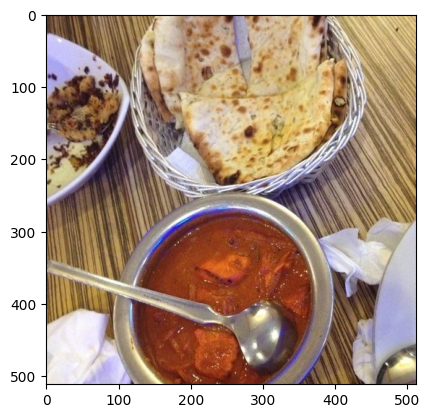

In [56]:
import matplotlib.image as mpimg  # For reading images
import matplotlib.pyplot as plt  # For displaying images


# View a single image
target_dir = "data/food_101_all_data/images/"
target_class = "chicken_curry"
target_path = target_dir+target_class
file_names = os.listdir(target_path)
target_img = target_path + "/" + random.sample(file_names, 1)[0]
print(target_img)

img = mpimg.imread(target_img)
plt.imshow(img);

In [57]:
def view_three_images(target_dir, target_class):
    """
    Randomly selects and displays 3 random images from `target_class` folder in `target_dir` folder.
    
    Requires target_dir to be in format:
        target_dir
                 |target_class_1
                 |target_class_2
                 |...
                 
    """
    target_path = target_dir+target_class
    file_names = os.listdir(target_path)
    target_images = random.sample(file_names, 3)
    
    # Plot images
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(target_images):
        img_path = target_path + "/" + img
        plt.subplot(1, 3, i+1)
        plt.imshow(mpimg.imread(img_path))
        plt.title(target_class)
        plt.axis("off")

Exception ignored in: <function tqdm.__del__ at 0x00000213B0F62DE0>
Traceback (most recent call last):
  File "C:\Users\shubham\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\shubham\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


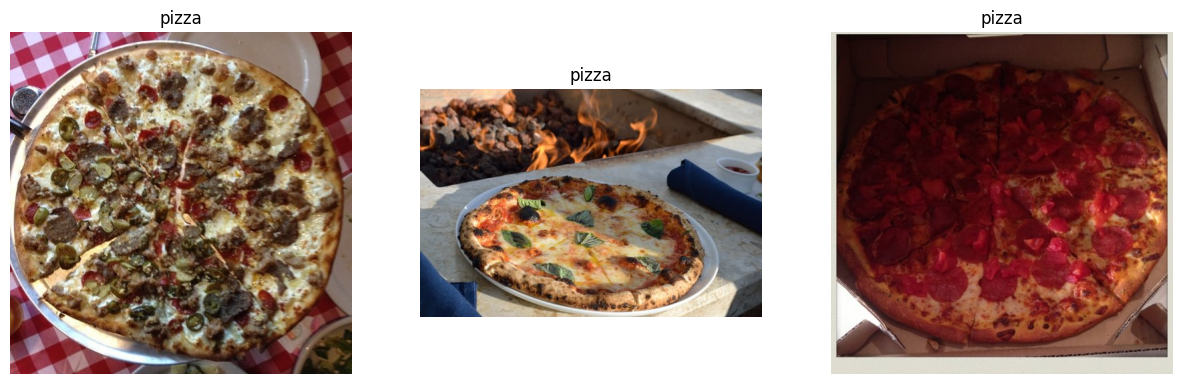

In [58]:
view_three_images(target_dir="data/food_101_all_data/images/", 
                  target_class="pizza")

## Make 10 class dataset

Pick 10 classes and create a folder with 10 datasets.

In [60]:
!dir data\food_101_all_data\meta\meta

 Volume in drive D is New Volume
 Volume Serial Number is D6C8-3FC2

 Directory of D:\personal\tensorflow-handson\03_computer_vision_with_tensorflow\data\food_101_all_data\meta\meta

11/24/2024  09:30 AM    <DIR>          .
11/24/2024  09:30 AM    <DIR>          ..
09/20/2019  10:06 PM             1,184 classes.txt
09/20/2019  10:06 PM             1,184 labels.txt
09/20/2019  10:06 PM           566,868 test.json
09/20/2019  10:06 PM           489,429 test.txt
09/20/2019  10:06 PM         1,697,751 train.json
09/20/2019  10:06 PM         1,468,812 train.txt
               6 File(s)      4,225,228 bytes
               2 Dir(s)  53,005,070,336 bytes free


In [61]:
# Get all classnames
classes = []
with open("data/food_101_all_data/meta/meta/classes.txt") as f:
    for line in f.readlines():
        classes.append(line.split("\n")[0]) 

classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [63]:
ten_classes = ["pizza", "steak", "sushi", "ramen", "chicken_wings",
               "chicken_curry", "hamburger", "fried_rice", "grilled_salmon", 
               "ice_cream"]
len(ten_classes)

10

In [64]:
parent_folder = "data"
new_subset = "10_food_classes"
datasets = ["train", "test"]

# Copy training/test images
for i in datasets:
    copy_images(parent_folder=parent_folder,
                new_subset=new_subset,
                dataset=i,
                #labels=labels,
                target_labels=ten_classes)


Using train labels...
Copied 750 images from train dataset pizza class...
Copied 750 images from train dataset steak class...
Copied 750 images from train dataset sushi class...
Copied 750 images from train dataset ramen class...
Copied 750 images from train dataset chicken_wings class...
Copied 750 images from train dataset chicken_curry class...
Copied 750 images from train dataset hamburger class...
Copied 750 images from train dataset fried_rice class...
Copied 750 images from train dataset grilled_salmon class...
Copied 750 images from train dataset ice_cream class...

Using test labels...
Copied 250 images from test dataset pizza class...
Copied 250 images from test dataset steak class...
Copied 250 images from test dataset sushi class...
Copied 250 images from test dataset ramen class...
Copied 250 images from test dataset chicken_wings class...
Copied 250 images from test dataset chicken_curry class...
Copied 250 images from test dataset hamburger class...
Copied 250 images fr

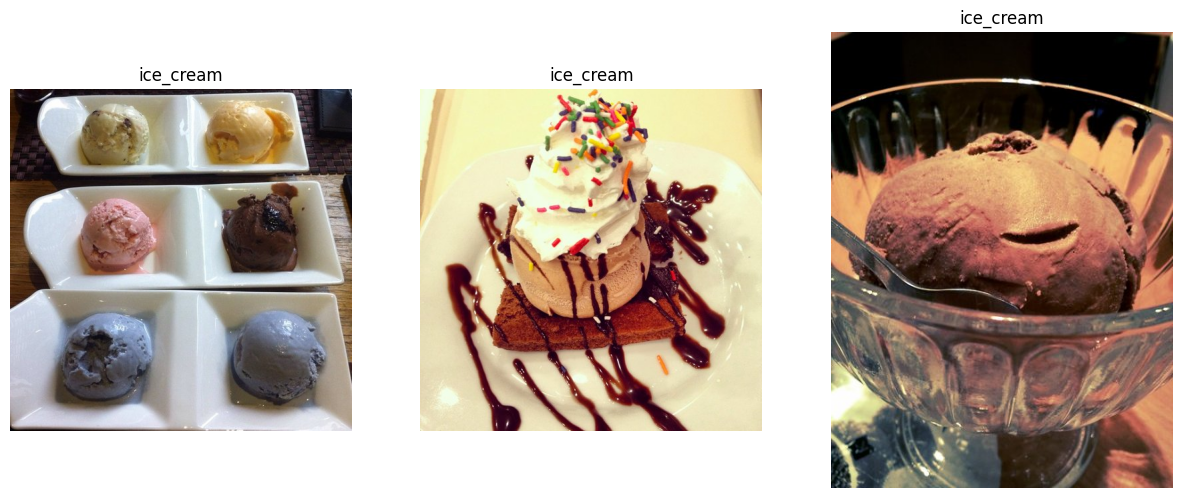

In [65]:
view_three_images(target_dir="data/food_101_all_data/images/", 
                  target_class="ice_cream")

In [66]:
# Make 10% dataset of 10_food_classes (of training data only)
get_percent_images(target_dir="data/10_food_classes/train/",
                   new_dir="data/10_food_classes_10_percent/train/",
                   sample_amount=0.1, # 1%
                   random_state=42)

There are 750 total images in 'data/10_food_classes/train/chicken_curry' so we're going to copy 75 to the new directory.
Getting 75 random images for chicken_curry...
Making dir: data/10_food_classes_10_percent/train/chicken_curry
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/chicken_curry/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 51.60it/s]


There are 750 total images in 'data/10_food_classes/train/chicken_wings' so we're going to copy 75 to the new directory.
Getting 75 random images for chicken_wings...
Making dir: data/10_food_classes_10_percent/train/chicken_wings
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/chicken_wings/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 51.13it/s]


There are 750 total images in 'data/10_food_classes/train/fried_rice' so we're going to copy 75 to the new directory.
Getting 75 random images for fried_rice...
Making dir: data/10_food_classes_10_percent/train/fried_rice
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/fried_rice/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 50.53it/s]


There are 750 total images in 'data/10_food_classes/train/grilled_salmon' so we're going to copy 75 to the new directory.
Getting 75 random images for grilled_salmon...
Making dir: data/10_food_classes_10_percent/train/grilled_salmon
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/grilled_salmon/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 50.70it/s]


There are 750 total images in 'data/10_food_classes/train/hamburger' so we're going to copy 75 to the new directory.
Getting 75 random images for hamburger...
Making dir: data/10_food_classes_10_percent/train/hamburger
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/hamburger/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 50.94it/s]


There are 750 total images in 'data/10_food_classes/train/ice_cream' so we're going to copy 75 to the new directory.
Getting 75 random images for ice_cream...
Making dir: data/10_food_classes_10_percent/train/ice_cream
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/ice_cream/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 50.83it/s]


There are 750 total images in 'data/10_food_classes/train/pizza' so we're going to copy 75 to the new directory.
Getting 75 random images for pizza...
Making dir: data/10_food_classes_10_percent/train/pizza
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/pizza/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 52.27it/s]


There are 750 total images in 'data/10_food_classes/train/ramen' so we're going to copy 75 to the new directory.
Getting 75 random images for ramen...
Making dir: data/10_food_classes_10_percent/train/ramen
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/ramen/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 51.06it/s]


There are 750 total images in 'data/10_food_classes/train/steak' so we're going to copy 75 to the new directory.
Getting 75 random images for steak...
Making dir: data/10_food_classes_10_percent/train/steak
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/steak/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 50.53it/s]


There are 750 total images in 'data/10_food_classes/train/sushi' so we're going to copy 75 to the new directory.
Getting 75 random images for sushi...
Making dir: data/10_food_classes_10_percent/train/sushi
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_10_percent/train/sushi/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 52.95it/s]


In [67]:
# Make 1% dataset of 10_food_classes (of training data only)
get_percent_images(target_dir="data/10_food_classes/train/",
                   new_dir="data/10_food_classes_1_percent/train/",
                   sample_amount=0.01, # 1%
                   random_state=42)

There are 750 total images in 'data/10_food_classes/train/chicken_curry' so we're going to copy 7 to the new directory.
Getting 7 random images for chicken_curry...
Making dir: data/10_food_classes_1_percent/train/chicken_curry
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/chicken_curry/



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 778.60it/s]


There are 750 total images in 'data/10_food_classes/train/chicken_wings' so we're going to copy 7 to the new directory.
Getting 7 random images for chicken_wings...
Making dir: data/10_food_classes_1_percent/train/chicken_wings
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/chicken_wings/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 72.59it/s]


There are 750 total images in 'data/10_food_classes/train/fried_rice' so we're going to copy 7 to the new directory.
Getting 7 random images for fried_rice...
Making dir: data/10_food_classes_1_percent/train/fried_rice
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/fried_rice/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 55.33it/s]


There are 750 total images in 'data/10_food_classes/train/grilled_salmon' so we're going to copy 7 to the new directory.
Getting 7 random images for grilled_salmon...
Making dir: data/10_food_classes_1_percent/train/grilled_salmon
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/grilled_salmon/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 57.55it/s]


There are 750 total images in 'data/10_food_classes/train/hamburger' so we're going to copy 7 to the new directory.
Getting 7 random images for hamburger...
Making dir: data/10_food_classes_1_percent/train/hamburger
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/hamburger/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 52.11it/s]


There are 750 total images in 'data/10_food_classes/train/ice_cream' so we're going to copy 7 to the new directory.
Getting 7 random images for ice_cream...
Making dir: data/10_food_classes_1_percent/train/ice_cream
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/ice_cream/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 49.91it/s]


There are 750 total images in 'data/10_food_classes/train/pizza' so we're going to copy 7 to the new directory.
Getting 7 random images for pizza...
Making dir: data/10_food_classes_1_percent/train/pizza
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/pizza/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 50.65it/s]


There are 750 total images in 'data/10_food_classes/train/ramen' so we're going to copy 7 to the new directory.
Getting 7 random images for ramen...
Making dir: data/10_food_classes_1_percent/train/ramen
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/ramen/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.34it/s]


There are 750 total images in 'data/10_food_classes/train/steak' so we're going to copy 7 to the new directory.
Getting 7 random images for steak...
Making dir: data/10_food_classes_1_percent/train/steak
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/steak/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.36it/s]


There are 750 total images in 'data/10_food_classes/train/sushi' so we're going to copy 7 to the new directory.
Getting 7 random images for sushi...
Making dir: data/10_food_classes_1_percent/train/sushi
Copying images from: data/10_food_classes/train/
		 to: data/10_food_classes_1_percent/train/sushi/



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.86it/s]


## Split whole dataset into train and test

In [68]:
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [69]:
parent_folder = "data"
new_subset = "all_food_classes"
datasets = ["train", "test"]

# Copy training/test images
for i in datasets:
    copy_images(parent_folder=parent_folder,
                new_subset=new_subset,
                dataset=i,
                target_labels=classes)


Using train labels...
Copied 750 images from train dataset apple_pie class...
Copied 750 images from train dataset baby_back_ribs class...
Copied 750 images from train dataset baklava class...
Copied 750 images from train dataset beef_carpaccio class...
Copied 750 images from train dataset beef_tartare class...
Copied 750 images from train dataset beet_salad class...
Copied 750 images from train dataset beignets class...
Copied 750 images from train dataset bibimbap class...
Copied 750 images from train dataset bread_pudding class...
Copied 750 images from train dataset breakfast_burrito class...
Copied 750 images from train dataset bruschetta class...
Copied 750 images from train dataset caesar_salad class...
Copied 750 images from train dataset cannoli class...
Copied 750 images from train dataset caprese_salad class...
Copied 750 images from train dataset carrot_cake class...
Copied 750 images from train dataset ceviche class...
Copied 750 images from train dataset cheesecake class

In [70]:
# Make 10% of all class images
get_percent_images(target_dir="data/all_food_classes/train/",
                   new_dir="data/all_food_classes_10_percent/train/",
                   sample_amount=0.1, # 10%
                   random_state=42)

There are 750 total images in 'data/all_food_classes/train/apple_pie' so we're going to copy 75 to the new directory.
Getting 75 random images for apple_pie...
Making dir: data/all_food_classes_10_percent/train/apple_pie
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/apple_pie/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 104.41it/s]


There are 750 total images in 'data/all_food_classes/train/baby_back_ribs' so we're going to copy 75 to the new directory.
Getting 75 random images for baby_back_ribs...
Making dir: data/all_food_classes_10_percent/train/baby_back_ribs
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/baby_back_ribs/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.82it/s]


There are 750 total images in 'data/all_food_classes/train/baklava' so we're going to copy 75 to the new directory.
Getting 75 random images for baklava...
Making dir: data/all_food_classes_10_percent/train/baklava
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/baklava/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.08it/s]


There are 750 total images in 'data/all_food_classes/train/beef_carpaccio' so we're going to copy 75 to the new directory.
Getting 75 random images for beef_carpaccio...
Making dir: data/all_food_classes_10_percent/train/beef_carpaccio
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/beef_carpaccio/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 107.24it/s]


There are 750 total images in 'data/all_food_classes/train/beef_tartare' so we're going to copy 75 to the new directory.
Getting 75 random images for beef_tartare...
Making dir: data/all_food_classes_10_percent/train/beef_tartare
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/beef_tartare/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.99it/s]


There are 750 total images in 'data/all_food_classes/train/beet_salad' so we're going to copy 75 to the new directory.
Getting 75 random images for beet_salad...
Making dir: data/all_food_classes_10_percent/train/beet_salad
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/beet_salad/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 93.29it/s]


There are 750 total images in 'data/all_food_classes/train/beignets' so we're going to copy 75 to the new directory.
Getting 75 random images for beignets...
Making dir: data/all_food_classes_10_percent/train/beignets
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/beignets/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.89it/s]


There are 750 total images in 'data/all_food_classes/train/bibimbap' so we're going to copy 75 to the new directory.
Getting 75 random images for bibimbap...
Making dir: data/all_food_classes_10_percent/train/bibimbap
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/bibimbap/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 108.70it/s]


There are 750 total images in 'data/all_food_classes/train/bread_pudding' so we're going to copy 75 to the new directory.
Getting 75 random images for bread_pudding...
Making dir: data/all_food_classes_10_percent/train/bread_pudding
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/bread_pudding/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.53it/s]


There are 750 total images in 'data/all_food_classes/train/breakfast_burrito' so we're going to copy 75 to the new directory.
Getting 75 random images for breakfast_burrito...
Making dir: data/all_food_classes_10_percent/train/breakfast_burrito
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/breakfast_burrito/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 109.99it/s]


There are 750 total images in 'data/all_food_classes/train/bruschetta' so we're going to copy 75 to the new directory.
Getting 75 random images for bruschetta...
Making dir: data/all_food_classes_10_percent/train/bruschetta
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/bruschetta/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 108.21it/s]


There are 750 total images in 'data/all_food_classes/train/caesar_salad' so we're going to copy 75 to the new directory.
Getting 75 random images for caesar_salad...
Making dir: data/all_food_classes_10_percent/train/caesar_salad
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/caesar_salad/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 108.30it/s]


There are 750 total images in 'data/all_food_classes/train/cannoli' so we're going to copy 75 to the new directory.
Getting 75 random images for cannoli...
Making dir: data/all_food_classes_10_percent/train/cannoli
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/cannoli/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 104.18it/s]


There are 750 total images in 'data/all_food_classes/train/caprese_salad' so we're going to copy 75 to the new directory.
Getting 75 random images for caprese_salad...
Making dir: data/all_food_classes_10_percent/train/caprese_salad
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/caprese_salad/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 113.23it/s]


There are 750 total images in 'data/all_food_classes/train/carrot_cake' so we're going to copy 75 to the new directory.
Getting 75 random images for carrot_cake...
Making dir: data/all_food_classes_10_percent/train/carrot_cake
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/carrot_cake/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 105.85it/s]


There are 750 total images in 'data/all_food_classes/train/ceviche' so we're going to copy 75 to the new directory.
Getting 75 random images for ceviche...
Making dir: data/all_food_classes_10_percent/train/ceviche
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/ceviche/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.57it/s]


There are 750 total images in 'data/all_food_classes/train/cheesecake' so we're going to copy 75 to the new directory.
Getting 75 random images for cheesecake...
Making dir: data/all_food_classes_10_percent/train/cheesecake
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/cheesecake/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.89it/s]


There are 750 total images in 'data/all_food_classes/train/cheese_plate' so we're going to copy 75 to the new directory.
Getting 75 random images for cheese_plate...
Making dir: data/all_food_classes_10_percent/train/cheese_plate
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/cheese_plate/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 105.66it/s]


There are 750 total images in 'data/all_food_classes/train/chicken_curry' so we're going to copy 75 to the new directory.
Getting 75 random images for chicken_curry...
Making dir: data/all_food_classes_10_percent/train/chicken_curry
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/chicken_curry/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.60it/s]


There are 750 total images in 'data/all_food_classes/train/chicken_quesadilla' so we're going to copy 75 to the new directory.
Getting 75 random images for chicken_quesadilla...
Making dir: data/all_food_classes_10_percent/train/chicken_quesadilla
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/chicken_quesadilla/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.28it/s]


There are 750 total images in 'data/all_food_classes/train/chicken_wings' so we're going to copy 75 to the new directory.
Getting 75 random images for chicken_wings...
Making dir: data/all_food_classes_10_percent/train/chicken_wings
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/chicken_wings/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 108.35it/s]


There are 750 total images in 'data/all_food_classes/train/chocolate_cake' so we're going to copy 75 to the new directory.
Getting 75 random images for chocolate_cake...
Making dir: data/all_food_classes_10_percent/train/chocolate_cake
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/chocolate_cake/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 97.68it/s]


There are 750 total images in 'data/all_food_classes/train/chocolate_mousse' so we're going to copy 75 to the new directory.
Getting 75 random images for chocolate_mousse...
Making dir: data/all_food_classes_10_percent/train/chocolate_mousse
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/chocolate_mousse/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.82it/s]


There are 750 total images in 'data/all_food_classes/train/churros' so we're going to copy 75 to the new directory.
Getting 75 random images for churros...
Making dir: data/all_food_classes_10_percent/train/churros
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/churros/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.56it/s]


There are 750 total images in 'data/all_food_classes/train/clam_chowder' so we're going to copy 75 to the new directory.
Getting 75 random images for clam_chowder...
Making dir: data/all_food_classes_10_percent/train/clam_chowder
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/clam_chowder/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 105.22it/s]


There are 750 total images in 'data/all_food_classes/train/club_sandwich' so we're going to copy 75 to the new directory.
Getting 75 random images for club_sandwich...
Making dir: data/all_food_classes_10_percent/train/club_sandwich
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/club_sandwich/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.63it/s]


There are 750 total images in 'data/all_food_classes/train/crab_cakes' so we're going to copy 75 to the new directory.
Getting 75 random images for crab_cakes...
Making dir: data/all_food_classes_10_percent/train/crab_cakes
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/crab_cakes/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 104.44it/s]


There are 750 total images in 'data/all_food_classes/train/creme_brulee' so we're going to copy 75 to the new directory.
Getting 75 random images for creme_brulee...
Making dir: data/all_food_classes_10_percent/train/creme_brulee
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/creme_brulee/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.00it/s]


There are 750 total images in 'data/all_food_classes/train/croque_madame' so we're going to copy 75 to the new directory.
Getting 75 random images for croque_madame...
Making dir: data/all_food_classes_10_percent/train/croque_madame
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/croque_madame/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.23it/s]


There are 750 total images in 'data/all_food_classes/train/cup_cakes' so we're going to copy 75 to the new directory.
Getting 75 random images for cup_cakes...
Making dir: data/all_food_classes_10_percent/train/cup_cakes
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/cup_cakes/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.37it/s]


There are 750 total images in 'data/all_food_classes/train/deviled_eggs' so we're going to copy 75 to the new directory.
Getting 75 random images for deviled_eggs...
Making dir: data/all_food_classes_10_percent/train/deviled_eggs
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/deviled_eggs/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.36it/s]


There are 750 total images in 'data/all_food_classes/train/donuts' so we're going to copy 75 to the new directory.
Getting 75 random images for donuts...
Making dir: data/all_food_classes_10_percent/train/donuts
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/donuts/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.30it/s]


There are 750 total images in 'data/all_food_classes/train/dumplings' so we're going to copy 75 to the new directory.
Getting 75 random images for dumplings...
Making dir: data/all_food_classes_10_percent/train/dumplings
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/dumplings/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.27it/s]


There are 750 total images in 'data/all_food_classes/train/edamame' so we're going to copy 75 to the new directory.
Getting 75 random images for edamame...
Making dir: data/all_food_classes_10_percent/train/edamame
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/edamame/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.02it/s]


There are 750 total images in 'data/all_food_classes/train/eggs_benedict' so we're going to copy 75 to the new directory.
Getting 75 random images for eggs_benedict...
Making dir: data/all_food_classes_10_percent/train/eggs_benedict
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/eggs_benedict/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.69it/s]


There are 750 total images in 'data/all_food_classes/train/escargots' so we're going to copy 75 to the new directory.
Getting 75 random images for escargots...
Making dir: data/all_food_classes_10_percent/train/escargots
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/escargots/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.57it/s]


There are 750 total images in 'data/all_food_classes/train/falafel' so we're going to copy 75 to the new directory.
Getting 75 random images for falafel...
Making dir: data/all_food_classes_10_percent/train/falafel
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/falafel/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 108.37it/s]


There are 750 total images in 'data/all_food_classes/train/filet_mignon' so we're going to copy 75 to the new directory.
Getting 75 random images for filet_mignon...
Making dir: data/all_food_classes_10_percent/train/filet_mignon
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/filet_mignon/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.49it/s]


There are 750 total images in 'data/all_food_classes/train/fish_and_chips' so we're going to copy 75 to the new directory.
Getting 75 random images for fish_and_chips...
Making dir: data/all_food_classes_10_percent/train/fish_and_chips
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/fish_and_chips/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 111.70it/s]


There are 750 total images in 'data/all_food_classes/train/foie_gras' so we're going to copy 75 to the new directory.
Getting 75 random images for foie_gras...
Making dir: data/all_food_classes_10_percent/train/foie_gras
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/foie_gras/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.27it/s]


There are 750 total images in 'data/all_food_classes/train/french_fries' so we're going to copy 75 to the new directory.
Getting 75 random images for french_fries...
Making dir: data/all_food_classes_10_percent/train/french_fries
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/french_fries/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 95.22it/s]


There are 750 total images in 'data/all_food_classes/train/french_onion_soup' so we're going to copy 75 to the new directory.
Getting 75 random images for french_onion_soup...
Making dir: data/all_food_classes_10_percent/train/french_onion_soup
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/french_onion_soup/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.47it/s]


There are 750 total images in 'data/all_food_classes/train/french_toast' so we're going to copy 75 to the new directory.
Getting 75 random images for french_toast...
Making dir: data/all_food_classes_10_percent/train/french_toast
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/french_toast/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.47it/s]


There are 750 total images in 'data/all_food_classes/train/fried_calamari' so we're going to copy 75 to the new directory.
Getting 75 random images for fried_calamari...
Making dir: data/all_food_classes_10_percent/train/fried_calamari
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/fried_calamari/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 104.29it/s]


There are 750 total images in 'data/all_food_classes/train/fried_rice' so we're going to copy 75 to the new directory.
Getting 75 random images for fried_rice...
Making dir: data/all_food_classes_10_percent/train/fried_rice
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/fried_rice/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 93.86it/s]


There are 750 total images in 'data/all_food_classes/train/frozen_yogurt' so we're going to copy 75 to the new directory.
Getting 75 random images for frozen_yogurt...
Making dir: data/all_food_classes_10_percent/train/frozen_yogurt
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/frozen_yogurt/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 109.30it/s]


There are 750 total images in 'data/all_food_classes/train/garlic_bread' so we're going to copy 75 to the new directory.
Getting 75 random images for garlic_bread...
Making dir: data/all_food_classes_10_percent/train/garlic_bread
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/garlic_bread/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.64it/s]


There are 750 total images in 'data/all_food_classes/train/gnocchi' so we're going to copy 75 to the new directory.
Getting 75 random images for gnocchi...
Making dir: data/all_food_classes_10_percent/train/gnocchi
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/gnocchi/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.30it/s]


There are 750 total images in 'data/all_food_classes/train/greek_salad' so we're going to copy 75 to the new directory.
Getting 75 random images for greek_salad...
Making dir: data/all_food_classes_10_percent/train/greek_salad
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/greek_salad/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.35it/s]


There are 750 total images in 'data/all_food_classes/train/grilled_cheese_sandwich' so we're going to copy 75 to the new directory.
Getting 75 random images for grilled_cheese_sandwich...
Making dir: data/all_food_classes_10_percent/train/grilled_cheese_sandwich
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/grilled_cheese_sandwich/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.32it/s]


There are 750 total images in 'data/all_food_classes/train/grilled_salmon' so we're going to copy 75 to the new directory.
Getting 75 random images for grilled_salmon...
Making dir: data/all_food_classes_10_percent/train/grilled_salmon
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/grilled_salmon/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 118.45it/s]


There are 750 total images in 'data/all_food_classes/train/guacamole' so we're going to copy 75 to the new directory.
Getting 75 random images for guacamole...
Making dir: data/all_food_classes_10_percent/train/guacamole
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/guacamole/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 110.43it/s]


There are 750 total images in 'data/all_food_classes/train/gyoza' so we're going to copy 75 to the new directory.
Getting 75 random images for gyoza...
Making dir: data/all_food_classes_10_percent/train/gyoza
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/gyoza/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 95.50it/s]


There are 750 total images in 'data/all_food_classes/train/hamburger' so we're going to copy 75 to the new directory.
Getting 75 random images for hamburger...
Making dir: data/all_food_classes_10_percent/train/hamburger
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/hamburger/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.98it/s]


There are 750 total images in 'data/all_food_classes/train/hot_and_sour_soup' so we're going to copy 75 to the new directory.
Getting 75 random images for hot_and_sour_soup...
Making dir: data/all_food_classes_10_percent/train/hot_and_sour_soup
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/hot_and_sour_soup/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.43it/s]


There are 750 total images in 'data/all_food_classes/train/hot_dog' so we're going to copy 75 to the new directory.
Getting 75 random images for hot_dog...
Making dir: data/all_food_classes_10_percent/train/hot_dog
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/hot_dog/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.60it/s]


There are 750 total images in 'data/all_food_classes/train/huevos_rancheros' so we're going to copy 75 to the new directory.
Getting 75 random images for huevos_rancheros...
Making dir: data/all_food_classes_10_percent/train/huevos_rancheros
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/huevos_rancheros/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.87it/s]


There are 750 total images in 'data/all_food_classes/train/hummus' so we're going to copy 75 to the new directory.
Getting 75 random images for hummus...
Making dir: data/all_food_classes_10_percent/train/hummus
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/hummus/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.13it/s]


There are 750 total images in 'data/all_food_classes/train/ice_cream' so we're going to copy 75 to the new directory.
Getting 75 random images for ice_cream...
Making dir: data/all_food_classes_10_percent/train/ice_cream
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/ice_cream/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 97.76it/s]


There are 750 total images in 'data/all_food_classes/train/lasagna' so we're going to copy 75 to the new directory.
Getting 75 random images for lasagna...
Making dir: data/all_food_classes_10_percent/train/lasagna
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/lasagna/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 116.56it/s]


There are 750 total images in 'data/all_food_classes/train/lobster_bisque' so we're going to copy 75 to the new directory.
Getting 75 random images for lobster_bisque...
Making dir: data/all_food_classes_10_percent/train/lobster_bisque
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/lobster_bisque/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.30it/s]


There are 750 total images in 'data/all_food_classes/train/lobster_roll_sandwich' so we're going to copy 75 to the new directory.
Getting 75 random images for lobster_roll_sandwich...
Making dir: data/all_food_classes_10_percent/train/lobster_roll_sandwich
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/lobster_roll_sandwich/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.79it/s]


There are 750 total images in 'data/all_food_classes/train/macaroni_and_cheese' so we're going to copy 75 to the new directory.
Getting 75 random images for macaroni_and_cheese...
Making dir: data/all_food_classes_10_percent/train/macaroni_and_cheese
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/macaroni_and_cheese/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 94.12it/s]


There are 750 total images in 'data/all_food_classes/train/macarons' so we're going to copy 75 to the new directory.
Getting 75 random images for macarons...
Making dir: data/all_food_classes_10_percent/train/macarons
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/macarons/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.48it/s]


There are 750 total images in 'data/all_food_classes/train/miso_soup' so we're going to copy 75 to the new directory.
Getting 75 random images for miso_soup...
Making dir: data/all_food_classes_10_percent/train/miso_soup
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/miso_soup/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.48it/s]


There are 750 total images in 'data/all_food_classes/train/mussels' so we're going to copy 75 to the new directory.
Getting 75 random images for mussels...
Making dir: data/all_food_classes_10_percent/train/mussels
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/mussels/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.21it/s]


There are 750 total images in 'data/all_food_classes/train/nachos' so we're going to copy 75 to the new directory.
Getting 75 random images for nachos...
Making dir: data/all_food_classes_10_percent/train/nachos
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/nachos/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 100.62it/s]


There are 750 total images in 'data/all_food_classes/train/omelette' so we're going to copy 75 to the new directory.
Getting 75 random images for omelette...
Making dir: data/all_food_classes_10_percent/train/omelette
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/omelette/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.20it/s]


There are 750 total images in 'data/all_food_classes/train/onion_rings' so we're going to copy 75 to the new directory.
Getting 75 random images for onion_rings...
Making dir: data/all_food_classes_10_percent/train/onion_rings
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/onion_rings/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 107.68it/s]


There are 750 total images in 'data/all_food_classes/train/oysters' so we're going to copy 75 to the new directory.
Getting 75 random images for oysters...
Making dir: data/all_food_classes_10_percent/train/oysters
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/oysters/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 95.97it/s]


There are 750 total images in 'data/all_food_classes/train/pad_thai' so we're going to copy 75 to the new directory.
Getting 75 random images for pad_thai...
Making dir: data/all_food_classes_10_percent/train/pad_thai
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pad_thai/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.22it/s]


There are 750 total images in 'data/all_food_classes/train/paella' so we're going to copy 75 to the new directory.
Getting 75 random images for paella...
Making dir: data/all_food_classes_10_percent/train/paella
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/paella/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.26it/s]


There are 750 total images in 'data/all_food_classes/train/pancakes' so we're going to copy 75 to the new directory.
Getting 75 random images for pancakes...
Making dir: data/all_food_classes_10_percent/train/pancakes
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pancakes/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 93.63it/s]


There are 750 total images in 'data/all_food_classes/train/panna_cotta' so we're going to copy 75 to the new directory.
Getting 75 random images for panna_cotta...
Making dir: data/all_food_classes_10_percent/train/panna_cotta
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/panna_cotta/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.66it/s]


There are 750 total images in 'data/all_food_classes/train/peking_duck' so we're going to copy 75 to the new directory.
Getting 75 random images for peking_duck...
Making dir: data/all_food_classes_10_percent/train/peking_duck
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/peking_duck/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.94it/s]


There are 750 total images in 'data/all_food_classes/train/pho' so we're going to copy 75 to the new directory.
Getting 75 random images for pho...
Making dir: data/all_food_classes_10_percent/train/pho
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pho/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 109.73it/s]


There are 750 total images in 'data/all_food_classes/train/pizza' so we're going to copy 75 to the new directory.
Getting 75 random images for pizza...
Making dir: data/all_food_classes_10_percent/train/pizza
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pizza/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.01it/s]


There are 750 total images in 'data/all_food_classes/train/pork_chop' so we're going to copy 75 to the new directory.
Getting 75 random images for pork_chop...
Making dir: data/all_food_classes_10_percent/train/pork_chop
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pork_chop/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.24it/s]


There are 750 total images in 'data/all_food_classes/train/poutine' so we're going to copy 75 to the new directory.
Getting 75 random images for poutine...
Making dir: data/all_food_classes_10_percent/train/poutine
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/poutine/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.15it/s]


There are 750 total images in 'data/all_food_classes/train/prime_rib' so we're going to copy 75 to the new directory.
Getting 75 random images for prime_rib...
Making dir: data/all_food_classes_10_percent/train/prime_rib
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/prime_rib/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 110.34it/s]


There are 750 total images in 'data/all_food_classes/train/pulled_pork_sandwich' so we're going to copy 75 to the new directory.
Getting 75 random images for pulled_pork_sandwich...
Making dir: data/all_food_classes_10_percent/train/pulled_pork_sandwich
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/pulled_pork_sandwich/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.31it/s]


There are 750 total images in 'data/all_food_classes/train/ramen' so we're going to copy 75 to the new directory.
Getting 75 random images for ramen...
Making dir: data/all_food_classes_10_percent/train/ramen
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/ramen/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 105.16it/s]


There are 750 total images in 'data/all_food_classes/train/ravioli' so we're going to copy 75 to the new directory.
Getting 75 random images for ravioli...
Making dir: data/all_food_classes_10_percent/train/ravioli
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/ravioli/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 94.03it/s]


There are 750 total images in 'data/all_food_classes/train/red_velvet_cake' so we're going to copy 75 to the new directory.
Getting 75 random images for red_velvet_cake...
Making dir: data/all_food_classes_10_percent/train/red_velvet_cake
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/red_velvet_cake/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.23it/s]


There are 750 total images in 'data/all_food_classes/train/risotto' so we're going to copy 75 to the new directory.
Getting 75 random images for risotto...
Making dir: data/all_food_classes_10_percent/train/risotto
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/risotto/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.70it/s]


There are 750 total images in 'data/all_food_classes/train/samosa' so we're going to copy 75 to the new directory.
Getting 75 random images for samosa...
Making dir: data/all_food_classes_10_percent/train/samosa
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/samosa/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.82it/s]


There are 750 total images in 'data/all_food_classes/train/sashimi' so we're going to copy 75 to the new directory.
Getting 75 random images for sashimi...
Making dir: data/all_food_classes_10_percent/train/sashimi
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/sashimi/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 103.12it/s]


There are 750 total images in 'data/all_food_classes/train/scallops' so we're going to copy 75 to the new directory.
Getting 75 random images for scallops...
Making dir: data/all_food_classes_10_percent/train/scallops
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/scallops/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 92.99it/s]


There are 750 total images in 'data/all_food_classes/train/seaweed_salad' so we're going to copy 75 to the new directory.
Getting 75 random images for seaweed_salad...
Making dir: data/all_food_classes_10_percent/train/seaweed_salad
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/seaweed_salad/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 101.90it/s]


There are 750 total images in 'data/all_food_classes/train/shrimp_and_grits' so we're going to copy 75 to the new directory.
Getting 75 random images for shrimp_and_grits...
Making dir: data/all_food_classes_10_percent/train/shrimp_and_grits
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/shrimp_and_grits/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.03it/s]


There are 750 total images in 'data/all_food_classes/train/spaghetti_bolognese' so we're going to copy 75 to the new directory.
Getting 75 random images for spaghetti_bolognese...
Making dir: data/all_food_classes_10_percent/train/spaghetti_bolognese
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/spaghetti_bolognese/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 93.59it/s]


There are 750 total images in 'data/all_food_classes/train/spaghetti_carbonara' so we're going to copy 75 to the new directory.
Getting 75 random images for spaghetti_carbonara...
Making dir: data/all_food_classes_10_percent/train/spaghetti_carbonara
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/spaghetti_carbonara/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 109.93it/s]


There are 750 total images in 'data/all_food_classes/train/spring_rolls' so we're going to copy 75 to the new directory.
Getting 75 random images for spring_rolls...
Making dir: data/all_food_classes_10_percent/train/spring_rolls
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/spring_rolls/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 98.71it/s]


There are 750 total images in 'data/all_food_classes/train/steak' so we're going to copy 75 to the new directory.
Getting 75 random images for steak...
Making dir: data/all_food_classes_10_percent/train/steak
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/steak/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 106.57it/s]


There are 750 total images in 'data/all_food_classes/train/strawberry_shortcake' so we're going to copy 75 to the new directory.
Getting 75 random images for strawberry_shortcake...
Making dir: data/all_food_classes_10_percent/train/strawberry_shortcake
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/strawberry_shortcake/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 105.84it/s]


There are 750 total images in 'data/all_food_classes/train/sushi' so we're going to copy 75 to the new directory.
Getting 75 random images for sushi...
Making dir: data/all_food_classes_10_percent/train/sushi
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/sushi/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 94.17it/s]


There are 750 total images in 'data/all_food_classes/train/tacos' so we're going to copy 75 to the new directory.
Getting 75 random images for tacos...
Making dir: data/all_food_classes_10_percent/train/tacos
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/tacos/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 102.62it/s]


There are 750 total images in 'data/all_food_classes/train/takoyaki' so we're going to copy 75 to the new directory.
Getting 75 random images for takoyaki...
Making dir: data/all_food_classes_10_percent/train/takoyaki
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/takoyaki/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.25it/s]


There are 750 total images in 'data/all_food_classes/train/tiramisu' so we're going to copy 75 to the new directory.
Getting 75 random images for tiramisu...
Making dir: data/all_food_classes_10_percent/train/tiramisu
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/tiramisu/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 96.91it/s]


There are 750 total images in 'data/all_food_classes/train/tuna_tartare' so we're going to copy 75 to the new directory.
Getting 75 random images for tuna_tartare...
Making dir: data/all_food_classes_10_percent/train/tuna_tartare
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/tuna_tartare/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 95.81it/s]


There are 750 total images in 'data/all_food_classes/train/waffles' so we're going to copy 75 to the new directory.
Getting 75 random images for waffles...
Making dir: data/all_food_classes_10_percent/train/waffles
Copying images from: data/all_food_classes/train/
		 to: data/all_food_classes_10_percent/train/waffles/



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 97.08it/s]


In [71]:
# Copy all classes test folder into all classes percentage folders
ten_percent_test = "data/all_food_classes/test/"
shutil.copytree(ten_percent_test, "data/all_food_classes_10_percent/test/")

'data/all_food_classes_10_percent/test/'